In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import os
import numpy as np
import json
import cv2

import torch
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import webcolors

from minimal.dataset import FloorplanGraphDataset
from minimal.utils import draw_graph, ID_COLOR
from minimal.gen import generate_plan

%matplotlib inline

In [4]:
DATA_PATH = "./data/sample_list.txt"
OUT_PATH = "./dump"

In [5]:
fp_dataset = FloorplanGraphDataset(DATA_PATH)

In [6]:
sample = next(iter(fp_dataset))
_, nds, eds = sample

In [7]:
masks = generate_plan(nds, eds)

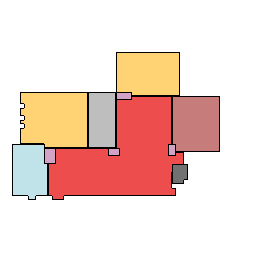

In [58]:
im_size = 256
real_nodes = np.where(nds == 1)[1]
room_imgs = masks.copy()

bg_img = Image.new(
    "RGBA", (im_size, im_size), (255, 255, 255, 255)
)  # Semitransparent background.

for m, nd in zip(room_imgs, real_nodes):
    # if nd not in [14,16]:
        # continue

    # resize map
    m[m > 0] = 255
    m[m < 0] = 0
    m_lg = cv2.resize(m, (im_size, im_size), interpolation=cv2.INTER_AREA)

    # pick color
    color = ID_COLOR[nd + 1]
    r, g, b = webcolors.hex_to_rgb(color)

    # set drawer
    dr_bkg = ImageDraw.Draw(bg_img)

    # draw region
    m_pil = Image.fromarray(m_lg)
    dr_bkg.bitmap((0, 0), m_pil.convert("L"), fill=(r, g, b, 256))

    # draw contour
    m_cv = m_lg[:, :, np.newaxis].astype("uint8")
    ret, thresh = cv2.threshold(m_cv, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if len(contours) > 0]
    cnt = np.zeros((256, 256, 3)).astype("uint8")
    cv2.drawContours(cnt, contours, -1, (255, 255, 255, 255), 1)
    cnt = Image.fromarray(cnt)
    dr_bkg.bitmap((0, 0), cnt.convert("L"), fill=(0, 0, 0, 255))

bg_img